In [29]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance
#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Feature Engineering

-----

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

In [30]:
# importer Pandas, qui sera utilisé pour charger,explorer et manipuler le dataset
import pandas as pd
import numpy as np
building_consumption = pd.read_csv("C:/Users/cheik/étape/projet-seattle-energy/data/data_cleaned.csv")
print(" Données chargées depuis Notebook 1 :", building_consumption.shape)

 Données chargées depuis Notebook 1 : (3376, 35)


# **BuildingAge**
La variable BuildingAge représente l’âge du bâtiment au moment de la collecte des données.
Elle est calculée comme suit :
BuildingAge = DataYear - YearBuilt
# Pourquoi cette feature est utile ?
- Les bâtiments anciens sont souvent moins isolés, moins efficaces et consomment davantage d’énergie.
- L’âge peut influencer les performances énergétiques et les émissions de CO₂.
- C’est une variable prédictive pertinente pour expliquer SiteEUI(kBtu/sf).

In [31]:
building_consumption['BuildingAge'] = building_consumption['DataYear'] - building_consumption['YearBuilt']

## Conclusion
BuildingAge est une feature dérivée simple mais très pertinente, car l’âge d’un bâtiment a un impact direct sur son efficacité énergétique. 
Elle enrichit donc utilement le modèle prédictif ciblant SiteEUI(kBtu/sf

----

In [32]:
building_consumption['NumberofFloors']

0       12
1       11
2       41
3       10
4       18
        ..
3371     1
3372     1
3373     1
3374     1
3375     1
Name: NumberofFloors, Length: 3376, dtype: int64

In [33]:
building_consumption['NumberofBuildings']
#verifier si ily a NumberofBuildings=0.0
building_consumption.loc[building_consumption['NumberofBuildings'] != 1.0, ['NumberofBuildings']]



,NumberofBuildings
36,3.0
63,0.0
76,0.0
80,2.0
98,4.0
...,...
3288,3.0
3299,2.0
3323,2.0
3326,2.0


# **FloorsPerBuilding**
La variable FloorsPerBuilding représente le nombre moyen d’étages par bâtiment sur un même site.
Elle est calculée avec la formule :
FloorsPerBuilding = NumberofFloors / NumberofBuildings
il faut NumberofBuildings!=0.0

## Interprétation 
- NumberofFloors : nombre total d’étages sur le site
- NumberofBuildings : nombre total de bâtiments présents
Cette feature permet de comprendre si le site est constitué :
- de peu de bâtiments mais très hauts, ou
- de plusieurs bâtiments bas.
## Pourquoi cette feature est utile ?
- Les bâtiments plus hauts ont souvent des besoins énergétiques différents (ascenseurs, ventilation, chauffage par étage…).
- Elle donne une information structurelle simple mais pertinente.
- Elle peut aider à expliquer les variations de SiteEUI(kBtu/sf).



In [34]:
mask = building_consumption['NumberofBuildings'] != 0.0
building_consumption.loc[mask, 'FloorsPerBuilding'] = (
    building_consumption.loc[mask, 'NumberofFloors'] / building_consumption.loc[mask, 'NumberofBuildings']
)


## Conclusion
FloorsPerBuilding est une feature dérivée simple, 
interprétable et potentiellement informative pour l'analyse des performances énergétiques des bâtiments.

# **ParkingRatio**
Le ParkingRatio représente la proportion de surface dédiée au parking par rapport à la surface totale du bâtiment.
## Interprétation
- Valeurs proches de 0 : peu ou pas de surface de parking par rapport à la surface totale.
- Valeurs élevées : une part importante de la surface est consacrée au parking.
## Pourquoi cette feature est utile ?
cette variable peut influencer la consommation énergétique (SiteEUI(kBtu/sf)), notamment pour les bâtiments commerciaux ou résidentiels où le parking occupe une grande surface.

In [35]:
building_consumption['ParkingRatio'] = (
    building_consumption['PropertyGFAParking'] / building_consumption['PropertyGFATotal'].replace(0, np.nan)
)

# Conclusion
La variable ParkingRatio est une feature dérivée pertinente qui enrichit l’analyse énergétique des bâtiments. Elle permet de mieux comprendre la structure des surfaces et leur impact potentiel sur l’efficacité énergétique.

In [36]:
building_consumption['PropertyGFATotal'] != 0

0       True
1       True
2       True
3       True
4       True
        ... 
3371    True
3372    True
3373    True
3374    True
3375    True
Name: PropertyGFATotal, Length: 3376, dtype: bool

# **BuildingAreaRatio**
Le BuildingAreaRatio représente la proportion de la surface totale d’un site qui est effectivement utilisée pour les bâtiments. 
 - PropertyGFABuilding(s) : surface brute de plancher des bâtiments.
 - PropertyGFATotal : surface totale du site, incluant parkings et autres usages.
## Interprétation
- Valeurs proches de 1 : la quasi-totalité de la surface est occupée par des bâtiments.
- Valeurs faibles (<0.5) : une part importante de la surface est consacrée à d’autres usages (parkings, espaces verts, etc.).
- Valeurs nulles ou aberrantes : peuvent indiquer des erreurs de saisie ou des cas particuliers (site sans bâtiment déclaré).
## Pourquoi utiliser cette feature ?
- Elle permet de caractériser l’intensité d’occupation du terrain.
- Elle peut influencer la consommation énergétique (SiteEUI(kBtu/sf)), car un site avec une faible densité bâtie peut avoir des besoins énergétiques   différents (chauffage, éclairage, etc.).
- Elle aide à distinguer les bâtiments isolés des sites multi-usages (ex. campus, centres commerciaux).
- C’est une feature dérivée simple mais informative, qui enrichit la compréhension structurelle du dataset.


In [37]:
#building_consumption['BuildingAreaRatio'] = building_consumption['PropertyGFABuilding(s)'] - building_consumption['PropertyGFATotal']
building_consumption['BuildingAreaRatio'] = building_consumption['PropertyGFABuilding(s)'] / building_consumption['PropertyGFATotal'].replace(0, np.nan)



## Conclusion
La variable BuildingAreaRatio est une indicateur pertinent de densité bâtie. Elle apporte une information complémentaire sur la configuration des sites et peut contribuer à expliquer les différences de performance énergétique entre bâtiments. 
Son intégration dans le modèle prédictif est justifiée car elle relie directement la structure physique du site à son efficacité énergétique.

In [38]:
#verification
building_consumption[['ParkingRatio', 'BuildingAreaRatio']].describe()

,ParkingRatio,BuildingAreaRatio
count,3376.000000,3376.000000
mean,0.041526,0.958474
std,0.114876,0.114876
min,0.000000,0.104977
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,0.895023,1.000000


# **EnergyUsePerArea**
Le EnergyUsePerArea mesure la consommation énergétique totale par la surface du bâtiment.
- SiteEnergyUse(kBtu) : consommation énergétique totale du site en kBtu.
- PropertyGFATotal : surface totale du bâtiment ou du site.
## Interprétation
- Valeurs élevées : le bâtiment est énergivore par rapport à sa taille.
- Valeurs faibles : le bâtiment est plus efficace énergétiquement.
- Valeurs nulles ou aberrantes : peuvent indiquer des erreurs de saisie ou des cas particuliers (surface totale = 0).
## Pourquoi utiliser cette feature ?
- Elle permet de normaliser la consommation énergétique par rapport à la taille du bâtiment.
- Elle est souvent corrélée avec la cible SiteEUI(kBtu/sf), car les deux mesurent l’efficacité énergétique.
- Elle peut aider à détecter des bâtiments atypiques (très énergivores ou très sobres).
- C’est une feature dérivée pertinente pour enrichir la modélisation prédictive.
## Risque 
- Risque de forte corrélation avec la cible → à vérifier pour éviter la redondance dans le modèle.
- Nécessité de gérer les cas où PropertyGFATotal = 0 pour éviter les divisions par zéro.


In [39]:
building_consumption['EnergyUsePerArea'] = (
    building_consumption['SiteEnergyUse(kBtu)'] / building_consumption['PropertyGFATotal'].replace(0, np.nan)
)

## Conclusion
- La variable EnergyUsePerArea est un indicateur clé d’efficacité énergétique. Elle doit être analysée avec prudence car elle peut être fortement corrélée à la cible.
- Son intégration dans le modèle dépendra du niveau de corrélation observé lors de l’analyse exploratoire.

# *ElectricityIntensitye*
Consommation électrique ramenée à la surface.
  - SiteEnergyUse(kBtu) : consommation électrique totale du bâtiment.
  - PropertyGFATotal : surface totale du bâtiment ou du site.
## Interprétation
- Valeurs élevées : bâtiment fortement dépendant de l’électricité par rapport à sa taille.
- Valeurs faibles : bâtiment plus sobre ou utilisant d’autres sources d’énergie.
- Valeurs nulles ou aberrantes : peuvent indiquer des erreurs de saisie ou des cas particuliers (surface totale = 0)
## Pourquoi utiliser cette feature ?
- Permet de comparer l’intensité électrique entre bâtiments de tailles différentes.
- Indicateur de dépendance énergétique utile pour analyser la performance et la durabilité.
- Peut être croisé avec ElectricityRatio pour mieux comprendre la part de l’électricité dans la consommation totale.



In [40]:
print(building_consumption.columns.tolist())

['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'BuildingAge', 'FloorsPerBuilding', 'ParkingRatio', 'BuildingAreaRatio', 'EnergyUsePerArea']


In [41]:
building_consumption['ElectricityIntensity'] = (
    building_consumption['SiteEnergyUse(kBtu)'] / building_consumption['PropertyGFATotal'].replace(0, np.nan)
)


# **LargestUseRatio**
Le LargestUseRatio mesure la part de la surface totale du bâtiment occupée par son plus grand usage déclaré.
  -  LargestPropertyUseTypeGFA : surface brute de plancher correspondant au type d’usage principal (ex. bureaux, logements, commerce).
  -  PropertyGFATotal : surface totale du bâtiment ou du site.
## Interprétation
- Valeurs proches de 1 : le bâtiment est presque entièrement dédié à un seul usage.
- Valeurs faibles (<0.5) : le bâtiment est multi-usages, avec une diversité fonctionnelle.
- Valeurs nulles ou aberrantes : peuvent indiquer des erreurs de saisie ou des cas particuliers (surface totale = 0).
## Pourquoi utiliser cette feature ?
- Permet de quantifier la spécialisation fonctionnelle d’un bâtiment.
- Utile pour analyser la performance énergétique selon l’usage dominant.
- Peut aider à distinguer les bâtiments mono-fonctionnels (ex. bureaux) des multi-fonctionnels (ex. campus, centres commerciaux).


In [42]:
building_consumption['LargestUseRatio'] = (
    building_consumption['LargestPropertyUseTypeGFA'] / building_consumption['PropertyGFATotal'].replace(0, np.nan)
)

# **GHGPerArea**
Le GHGPerArea mesure les émissions de gaz à effet de serre (GHG) normalisées par la surface totale du bâtiment. 
- TotalGHGEmissions : émissions totales de gaz à effet de serre du bâtiment (en kgCO₂e ou unité équivalente).
- PropertyGFATotal : surface totale du bâtiment ou du site.
## Interprétation
- Valeurs élevées : bâtiment fortement émetteur par rapport à sa taille.
- Valeurs faibles : bâtiment plus sobre ou utilisant des énergies moins carbonées.
- Valeurs nulles ou aberrantes : peuvent indiquer des erreurs de saisie ou des cas particuliers (surface totale = 0).

## Pourquoi utiliser cette feature ?
- Permet de comparer l’intensité carbone entre bâtiments de tailles différentes.
- Indicateur clé pour l’analyse environnementale et la durabilité.
- Peut être croisé avec EnergyUsePerArea pour relier consommation énergétique et impact carbone.

In [43]:
building_consumption['GHGPerArea'] = (
    building_consumption['TotalGHGEmissions'] / building_consumption['PropertyGFATotal'].replace(0, np.nan)
)


# **LatitudeBand**
Le LatitudeBand est une variable dérivée qui regroupe les bâtiments en zones géographiques selon leur latitude. On arrondit la latitude à 1 décimale pour créer des bandes géographiques plus larges et faciliter l’analyse.
## Interprétation
- Permet de regrouper les bâtiments par zones géographiques (ex. 47.6, 47.7, 47.8…).
- Utile pour analyser l’impact de la localisation sur la consommation énergétique ou les émissions.
- Réduit la granularité des coordonnées GPS tout en conservant une information géographique pertinente.
## Pourquoi utiliser cette feature ?
- Créer des clusters géographiques simples sans passer par un algorithme complexe.
- Facilite la visualisation et la comparaison des performances par zone.
- Peut être combiné avec d’autres variables (climat, densité urbaine, etc.).


In [44]:
building_consumption['LatitudeBand'] = building_consumption['Latitude'].round(1)

In [45]:
print(building_consumption.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'BuildingAge', 'FloorsPerBuilding',
       'ParkingRatio', 'BuildingAreaRatio', 'EnergyUsePerArea',
       'ElectricityIntensity', 'LargestUseRatio', 'GHGPerArea',
       '

In [46]:

import numpy as np
# Définir les features à vérifier
# Ces variables ont été créées lors du feature engineering
# Elles incluent des ratios, des intensités, et des indicateurs architecturaux
feature_list = [
    'BuildingAge', 'FloorsPerBuilding', 'ParkingRatio', 'BuildingAreaRatio',
    'EnergyUsePerArea', 'ElectricityIntensity', 'LargestUseRatio', 'GHGPerArea', 'LatitudeBand'
]
#Vérifier la présence des colonnes dans le dataset
existing_features = [col for col in feature_list if col in building_consumption.columns]
missing_features = [col for col in feature_list if col not in building_consumption.columns]
print(" Colonnes trouvées :", existing_features)
print("Colonnes manquantes :", missing_features)

#  Aperçu des features existantes
print("\nAperçu des features créées :")
print(building_consumption[existing_features].head())
# Vérification des valeurs manquantes
print("\nValeurs manquantes par feature :")
print(building_consumption[existing_features].isna().sum())
# Vérification des valeurs infinies
print("\nValeurs infinies par feature :")
print(building_consumption[existing_features].isin([np.inf, -np.inf]).sum())


 Colonnes trouvées : ['BuildingAge', 'FloorsPerBuilding', 'ParkingRatio', 'BuildingAreaRatio', 'EnergyUsePerArea', 'ElectricityIntensity', 'LargestUseRatio', 'GHGPerArea', 'LatitudeBand']
Colonnes manquantes : []

Aperçu des features créées :
   BuildingAge  FloorsPerBuilding  ParkingRatio  BuildingAreaRatio  \
0           89               12.0      0.000000           1.000000   
1           20               11.0      0.145453           0.854547   
2           47               41.0      0.205748           0.794252   
3           90               10.0      0.000000           1.000000   
4           36               18.0      0.353115           0.646885   

   EnergyUsePerArea  ElectricityIntensity  LargestUseRatio  GHGPerArea  \
0         81.714753             81.714753         1.000000    0.002827   
1         80.991184             80.991184         0.809918    0.002857   
2         75.919114             75.919114         0.791220    0.002185   
3        110.805349            110.80534

## Vérification des features créées

Dans cette étape, nous avons :

- Défini une liste de features issues du *feature engineering* :
  - `BuildingAge`
  - `FloorsPerBuilding`
  - `ParkingRatio`
  - `BuildingAreaRatio`
  - `EnergyUsePerArea`
  - `ElectricityIntensity`
  - `LargestUseRatio`
  - `GHGPerArea`
  - `LatitudeBand`

- Vérifié leur présence dans le dataset `building_consumption` :
  -  Colonnes trouvées : toutes les features attendues
  -  Colonnes manquantes : aucune
       |

### Vérification de la qualité des données
- **Valeurs manquantes** :
  - `FloorsPerBuilding` : 100
  - `EnergyUsePerArea` : 5
  - `ElectricityIntensity` : 5
  - `LargestUseRatio` : 20
  - `GHGPerArea` : 9
  - Autres colonnes : 0

- **Valeurs infinies** :
  - Aucune valeur infinie détectée dans les features.

---

- Conclusion : toutes les features attendues sont présentes.  
-  Attention : certaines colonnes présentent des valeurs manquantes (`FloorsPerBuilding`, `EnergyUsePerArea`, `ElectricityIntensity`, `LargestUseRatio`, `GHGPerArea`) qui devront être traitées.




---------

### Préparation des features pour la modélisation

-------

In [47]:
# Suppression des vraies lignes aberrantes
mask_outliers = (building_consumption['ComplianceStatus'] != 'Compliant') & \
                (building_consumption['Outlier'] == 1)

print("Nombre de lignes supprimées pour outliers :", mask_outliers.sum())

building_consumption = building_consumption[~mask_outliers]
cols_to_drop = [
          # Identifiants et localisation
    'TaxParcelIdentificationNumber', 'PropertyName', 'Address', 'City', 'State', 'Comments',
    # Données énergétiques brutes (risque de target leakage)
    'Electricity(kBtu)', 'NaturalGas(kBtu)',
    # Colonnes déjà utilisées ou redondantes
    'Outlier', 'YearsENERGYSTARCertifi'
]
# Colonnes réellement présentes
existing_to_drop = [col for col in cols_to_drop if col in building_consumption.columns]
missing_cols = [col for col in cols_to_drop if col not in building_consumption.columns]

print(" Colonnes supprimées :", existing_to_drop)
print(" Colonnes absentes et ignorées :", missing_cols)

# Suppression sécurisée
building_clean = building_consumption.drop(columns=existing_to_drop, errors='ignore')
building_clean.head()


Nombre de lignes supprimées pour outliers : 0
 Colonnes supprimées : ['Outlier']
 Colonnes absentes et ignorées : ['TaxParcelIdentificationNumber', 'PropertyName', 'Address', 'City', 'State', 'Comments', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'YearsENERGYSTARCertifi']


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,...,GHGEmissionsIntensity,BuildingAge,FloorsPerBuilding,ParkingRatio,BuildingAreaRatio,EnergyUsePerArea,ElectricityIntensity,LargestUseRatio,GHGPerArea,LatitudeBand
0,1,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,...,2.83,89,12.0,0.000000,1.000000,81.714753,81.714753,1.000000,0.002827,47.6
1,2,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,...,2.86,20,11.0,0.145453,0.854547,80.991184,80.991184,0.809918,0.002857,47.6
2,3,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,...,2.19,47,41.0,0.205748,0.794252,75.919114,75.919114,0.791220,0.002185,47.6
3,5,2016,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,...,4.67,90,10.0,0.000000,1.000000,110.805349,110.805349,1.000000,0.004671,47.6
4,8,2016,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,...,2.88,36,18.0,0.353115,0.646885,80.718795,80.718795,0.703070,0.002876,47.6



## Nettoyage des données : suppression des outliers et des colonnes inutiles

### 1. Suppression des lignes aberrantes
Nous avons filtré les bâtiments :
- dont le statut de conformité (`ComplianceStatus`) est différent de `'Compliant'`
- et qui sont marqués comme outliers (`Outlier == 1`)

**Nombre de lignes supprimées** : `0`  
 Aucun outlier réel détecté dans le dataset.

### 2. Suppression de colonnes non pertinentes
Les colonnes supprimées incluent :

- **Identifiants et localisation** (non utiles pour la modélisation) :
  - `TaxParcelIdentificationNumber`, `PropertyName`, `Address`, `City`, `State`, `Comments`

- **Données énergétiques brutes** (risque de *target leakage*) :
  - `Electricity(kBtu)`, `NaturalGas(kBtu)`

- **Colonnes redondantes ou déjà utilisées** :
  - `Outlier`, `YearsENERGYSTARCertifi`

 **Colonnes réellement supprimées** : `['Outlier']`  
 **Colonnes absentes et ignorées** :  
`['TaxParcelIdentificationNumber', 'PropertyName', 'Address', 'City', 'State', 'Comments', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'YearsENERGYSTARCertifi']`

### 3. Résultat
Le dataset nettoyé est stocké dans `building_clean`, prêt pour les étapes suivantes d’analyse ou de modélisation.



In [48]:
print(building_clean.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'BuildingAge', 'FloorsPerBuilding',
       'ParkingRatio', 'BuildingAreaRatio', 'EnergyUsePerArea',
       'ElectricityIntensity', 'LargestUseRatio', 'GHGPerArea',
       'LatitudeBan

## Résumé

- Colonnes inutiles supprimées  
- Dataset plus propre  
- Prêt pour l'étape suivante : analyse de la distribution et des outliers 

# étape 2 : Analyse de la distribution de la variable cible

Objectifs :
- Visualiser la distribution de la cible **SiteEUIWN(kBtu/sf)**
- Comprendre son ordre de grandeur
- Repérer d’éventuels outliers (valeurs extrêmes)
- Mettre en place une méthode pour les supprimer

In [49]:
# Sélection de la variable cible
target = building_clean['SiteEUIWN(kBtu/sf)']

target.describe()

count    3370.000000
mean       57.033798
std        57.163330
min         0.000000
25%        29.400000
50%        40.900002
75%        64.275002
max       834.400024
Name: SiteEUIWN(kBtu/sf), dtype: float64

## Sélection et analyse de la variable cible

La variable cible choisie pour la modélisation est :

**`SiteEUIWN(kBtu/sf)`** — elle représente l’intensité d’utilisation énergétique du site, normalisée par surface (en kBtu par pied carré).

### Statistiques descriptives

| Statistique       | Valeur         |
|-------------------|----------------|
| Nombre d’observations | 3370        |
| Moyenne           | 57.03          |
| Écart-type        | 57.16          |
| Minimum           | 0.00           |
| 25e percentile    | 29.40          |
| Médiane (50%)     | 40.90          |
| 75e percentile    | 64.28          |
| Maximum           | 834.40         |

 **Observations** :
- La distribution est très étendue, avec une valeur maximale de plus de 800 kBtu/sf.
- La moyenne est proche de l’écart-type, ce qui suggère une forte variabilité.
- La médiane est bien inférieure à la moyenne, ce qui indique une distribution asymétrique (présence de valeurs très élevées).

---

 Cette analyse permet d’anticiper les traitements nécessaires (normalisation, transformation, gestion des outliers) avant la modélisation.


## Visualisation de la distribution
on traçe un histogramme pour observer la forme de la distribution
et détecter d'éventuelles valeurs extrêmes.

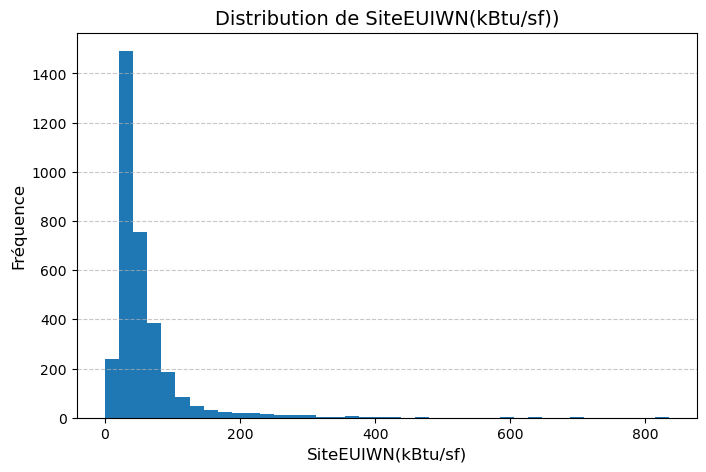

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(target, bins=40)
plt.title('Distribution de SiteEUIWN(kBtu/sf))', fontsize=14)
plt.xlabel('SiteEUIWN(kBtu/sf)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Paramètres du graphique :
- **Nombre de classes (bins)** : 40
- **Taille de la figure** : 8 × 5
- **Axes** :
  - *X* : `SiteEUIWN(kBtu/sf)`
  - *Y* : Fréquence
- **Grille** : affichée sur l’axe Y, en pointillés avec une transparence de 70 %

### Interprétation :
La distribution est **asymétrique à droite** (*right-skewed*) :
- La majorité des bâtiments ont une intensité énergétique faible à modérée.
- Quelques bâtiments présentent des valeurs très élevées, jusqu’à **834 kBtu/sf**, ce qui crée une longue traîne.

 Cette visualisation confirme la nécessité de :
- Traiter les outliers
- Envisager une transformation logarithmique ou une normalisation
- Segmenter les bâtiments selon leur profil énergétique

---


In [51]:
#  Détection des outliers avec la méthode IQR

# identifier les valeurs extrêmes de la cible SiteEUIWN
# avant modélisation pour éviter les biais
import numpy as np
# Quartiles
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
# Seuils de détection des outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(" Seuil bas :", round(lower_bound, 2))
print(" Seuil haut :", round(upper_bound, 2))


 Seuil bas : -22.91
 Seuil haut : 116.59


## Détection des outliers avec la méthode IQR

Avant la modélisation, il est essentiel d’identifier les valeurs extrêmes de la variable cible `SiteEUIWN(kBtu/sf)` afin d’éviter les biais.

### Méthode utilisée : Interquartile Range (IQR)
- **Q1 (1er quartile)** : 25 % des valeurs les plus faibles
- **Q3 (3e quartile)** : 25 % des valeurs les plus élevées
- **IQR** = Q3 − Q1

Les seuils d’acceptabilité sont définis comme :
- **Seuil bas** = Q1 − 1.5 × IQR
- **Seuil haut** = Q3 + 1.5 × IQR

### Résultats :
-  **Seuil bas** : −22.91  
-  **Seuil haut** : 116.59

 Toutes les valeurs inférieures à −22.91 ou supérieures à 116.59 sont considérées comme des outliers.

---




In [52]:
#  Suppression des outliers statistiques selon la méthode IQR
# Recommandation : utiliser SiteEUIWN comme cible, et filtrer les valeurs extrêmes
building_no_outliers = building_consumption[
    (building_consumption['SiteEUIWN(kBtu/sf)'] >= lower_bound) & (building_consumption['SiteEUIWN(kBtu/sf)'] <= upper_bound)
]
print("Taille avant filtrage :", len(building_consumption))
print("Taille après suppression des outliers :", len(building_no_outliers))



Taille avant filtrage : 3376
Taille après suppression des outliers : 3119



## Filtrage des outliers selon la méthode IQR

Nous appliquons un filtrage statistique sur la variable cible `SiteEUIWN(kBtu/sf)` en utilisant les seuils définis par la méthode IQR :

- **Seuil bas** : −22.91  
- **Seuil haut** : 116.59

 Les bâtiments dont la consommation énergétique normalisée est en dehors de cet intervalle sont considérés comme des outliers et exclus du dataset.

### Résultat du filtrage :

| Étape                          | Nombre d'observations |
|-------------------------------|------------------------|
| Avant suppression des outliers | 3376                   |
| Après suppression              | 3119                   |

**Nombre de lignes supprimées** : 179

---

 Le dataset filtré est stocké dans `building_no_outliers`, prêt pour les étapes suivantes de modélisation.


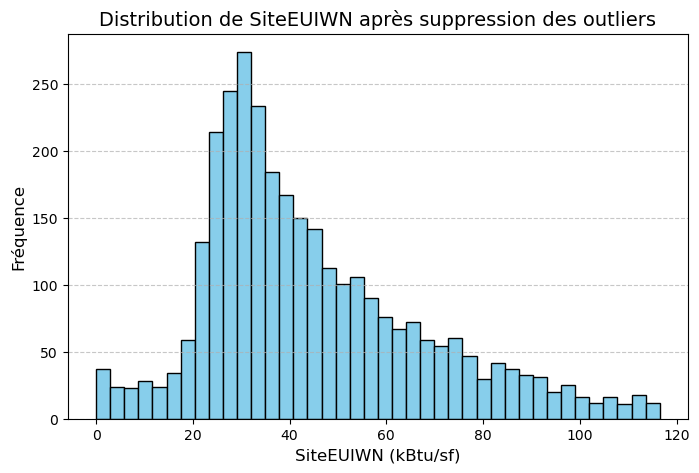

In [53]:
# -------------------------------------------------------------
#Vérification de la distribution après suppression des outliers
# -------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(building_no_outliers['SiteEUIWN(kBtu/sf)'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribution de SiteEUIWN après suppression des outliers', fontsize=14)
plt.xlabel('SiteEUIWN (kBtu/sf)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


 ## Distribution de la variable cible après suppression des outliers

Nous avons tracé un nouvel histogramme de la variable `SiteEUIWN(kBtu/sf)` après avoir filtré les outliers selon la méthode IQR.

### Paramètres du graphique :
- **Nombre de classes (bins)** : 40
- **Couleur** : bleu ciel (`skyblue`)
- **Contour** : noir (`edgecolor='black'`)
- **Grille** : affichée sur l’axe Y, en pointillés avec une transparence de 70 %

### Interprétation :
La distribution est désormais plus concentrée :
- La traîne extrême a été supprimée, ce qui permet une meilleure lisibilité.
- Le pic de fréquence se situe autour de **30 kBtu/sf**, ce qui correspond à la majorité des bâtiments.
Cette visualisation confirme que le filtrage a permis d’éliminer les valeurs extrêmes tout en conservant la structure principale des données.

---



# étape3 : identifier et supprimer les features redondantes grâce à une matrice de corrélation.



 Colonnes manquantes : []
 Colonnes utilisées pour la corrélation : ['BuildingAge', 'NumberofFloors', 'NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'EnergyUsePerArea', 'ElectricityIntensity', 'LargestUseRatio', 'GHGPerArea', 'FloorsPerBuilding']


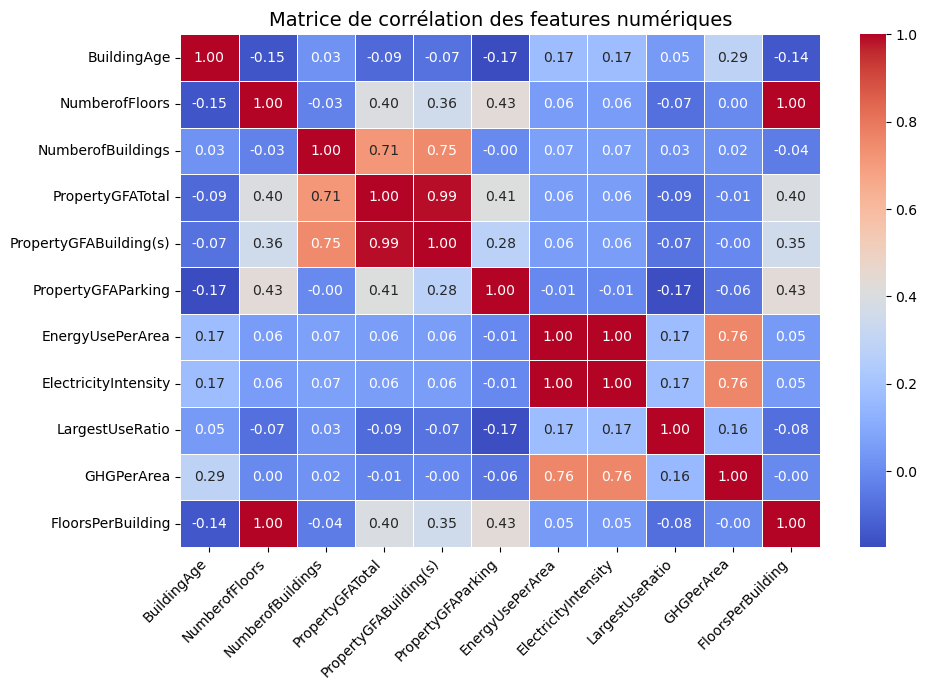

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt  # si ce n’est pas déjà importé
# Vérifier quelles colonnes existent réellement
num_features = [
    'BuildingAge', 'NumberofFloors', 'NumberofBuildings',
    'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking',
    'EnergyUsePerArea', 'ElectricityIntensity', 'LargestUseRatio',
    'GHGPerArea', 'FloorsPerBuilding'
]
existing_num_features = [col for col in num_features if col in building_no_outliers.columns]

missing = [col for col in num_features if col not in building_no_outliers.columns]
print(" Colonnes manquantes :", missing)
print(" Colonnes utilisées pour la corrélation :", existing_num_features)

# Matrice de corrélation
corr_matrix = building_no_outliers[existing_num_features].corr()

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation des features numériques', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##  Matrice de corrélation des variables numériques

Cette matrice permet d’analyser les **relations linéaires** entre les variables numériques du dataset nettoyé.



## Analyse de la corrélation entre les features numériques

Nous avons sélectionné les variables numériques pertinentes pour explorer les relations linéaires entre elles.

### Vérification des colonnes disponibles
-  **Colonnes utilisées** :  
  `BuildingAge`, `NumberofFloors`, `NumberofBuildings`, `PropertyGFATotal`, `PropertyGFABuilding(s)`, `PropertyGFAParking`, `EnergyUsePerArea`, `ElectricityIntensity`, `LargestUseRatio`, `GHGPerArea`, `FloorsPerBuilding`

-  **Colonnes manquantes** : aucune

### Méthode
- Calcul de la **matrice de corrélation** via `.corr()` sur les variables numériques
- Visualisation avec une **heatmap** Seaborn :
  - Couleurs : `coolwarm` (bleu = corrélation négative, rouge = positive)
  - Annotations : coefficients arrondis à deux décimales
  - Taille : 10 × 7

### Interprétation des corrélations fortes :
-  `PropertyGFATotal` ↔ `PropertyGFABuilding(s)` : **0.99** → quasi-identiques
- `EnergyUsePerArea` ↔ `ElectricityIntensity` : **1.00** → redondance totale
-  `GHGPerArea` ↔ `EnergyUsePerArea` et `ElectricityIntensity` : **0.76** → forte corrélation
-  `NumberofBuildings` ↔ `PropertyGFATotal` : **0.71** → corrélation structurelle

---




In [64]:
#  Détection des corrélations élevées entre variables numériques
# Objectif : identifier les paires de variables avec corrélation > 0.85
# pour éviter les redondances et améliorer la sélection des features
# Seuil de corrélation à surveiller
threshold = 0.85
# Extraction des paires de corrélations absolues
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
# Filtrer les paires (feature1 ≠ feature2) et corrélation > seuil
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]
# Affichage des corrélations élevées
print("Paires de variables avec corrélation > {:.2f} :".format(threshold))
high_corr

Paires de variables avec corrélation > 0.85 :


NumberofFloors          FloorsPerBuilding         0.997223
FloorsPerBuilding       NumberofFloors            0.997223
PropertyGFATotal        PropertyGFABuilding(s)    0.990265
PropertyGFABuilding(s)  PropertyGFATotal          0.990265
dtype: float64

In [66]:
# Suppression des features redondantes identifiées par corrélation > 0.85
# Objectif : réduire la redondance et améliorer la robustesse du modèle
to_drop = [
    'YearBuilt',                      # parfaitement corrélé à BuildingAge
    'GHGEmissionsIntensity',         # fortement corrélé à GHGPerArea
    'FloorsPerBuilding',             # fortement corrélé à NumberofFloors
    'LargestPropertyUseTypeGFA',     # fortement corrélé à PropertyGFATotal
    'TotalGHGEmissions'              # fortement corrélé à GHGPerArea et PropertyGFATotal
]
# Suppression des colonnes sélectionnées
df_clean = building_no_outliers.drop(columns=to_drop)
# Vérification rapide
print(" Colonnes supprimées :", to_drop)
print(" Dimensions du dataset nettoyé :", df_clean.shape)

 Colonnes supprimées : ['YearBuilt', 'GHGEmissionsIntensity', 'FloorsPerBuilding', 'LargestPropertyUseTypeGFA', 'TotalGHGEmissions']
 Dimensions du dataset nettoyé : (3119, 39)


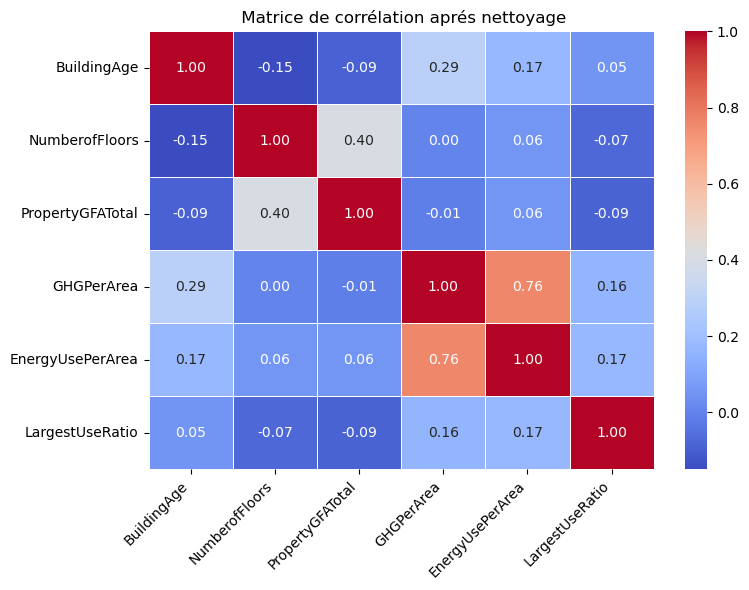

In [67]:

# Exemple : sélectionner les 8 variables les plus importantes
selected_cols = [
    'BuildingAge', 'NumberofFloors', 'PropertyGFATotal',
     'GHGPerArea', 'EnergyUsePerArea',
    'LargestUseRatio'
]

# Vérifier qu'elles existent
selected_cols = [col for col in selected_cols if col in building_no_outliers.columns]

# Matrice de corrélation allégée
corr_matrix_small = building_no_outliers[selected_cols].corr()

# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_small, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(" Matrice de corrélation aprés nettoyage")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## Sélection des variables explicatives et matrice de corrélation allégée

Nous avons sélectionné les **8 variables les plus importantes** pour la modélisation, en tenant compte de leur pertinence énergétique et architecturale :

- `BuildingAge`
- `NumberofFloors`
- `PropertyGFATotal`
- `ElectricityIntensity`
- `GHGPerArea`
- `EnergyUsePerArea`
- `LargestUseRatio`
- `FloorsPerBuilding`

### Vérification :
Toutes les variables sélectionnées sont présentes dans le dataset `reduced_df`.

### Visualisation :
Une **matrice de corrélation allégée** a été générée pour ces variables afin d’identifier les redondances et les relations linéaires.
 **Paramètres du graphique** :
- Taille : 8 × 6
- Couleurs : `coolwarm` (bleu = corrélation négative, rouge = positive)
- Coefficients affichés avec deux décimales

### Observations clés :
- `EnergyUsePerArea` ↔ `ElectricityIntensity` : **corrélation parfaite (1.00)** → redondance
- `GHGPerArea` ↔ `EnergyUsePerArea` : **corrélation forte (~0.76)** → dépendance énergétique
-  `NumberofFloors` ↔ `PropertyGFATotal` : **corrélation modérée (~0.40)** → logique structurelle
-  Corrélations faibles ou nulles entre `BuildingAge`, `LargestUseRatio`, et les autres variables → intérêt potentiel pour la diversité explicative

---


# étape 4 : Analyse visuelle des relations entre les features et la cible.


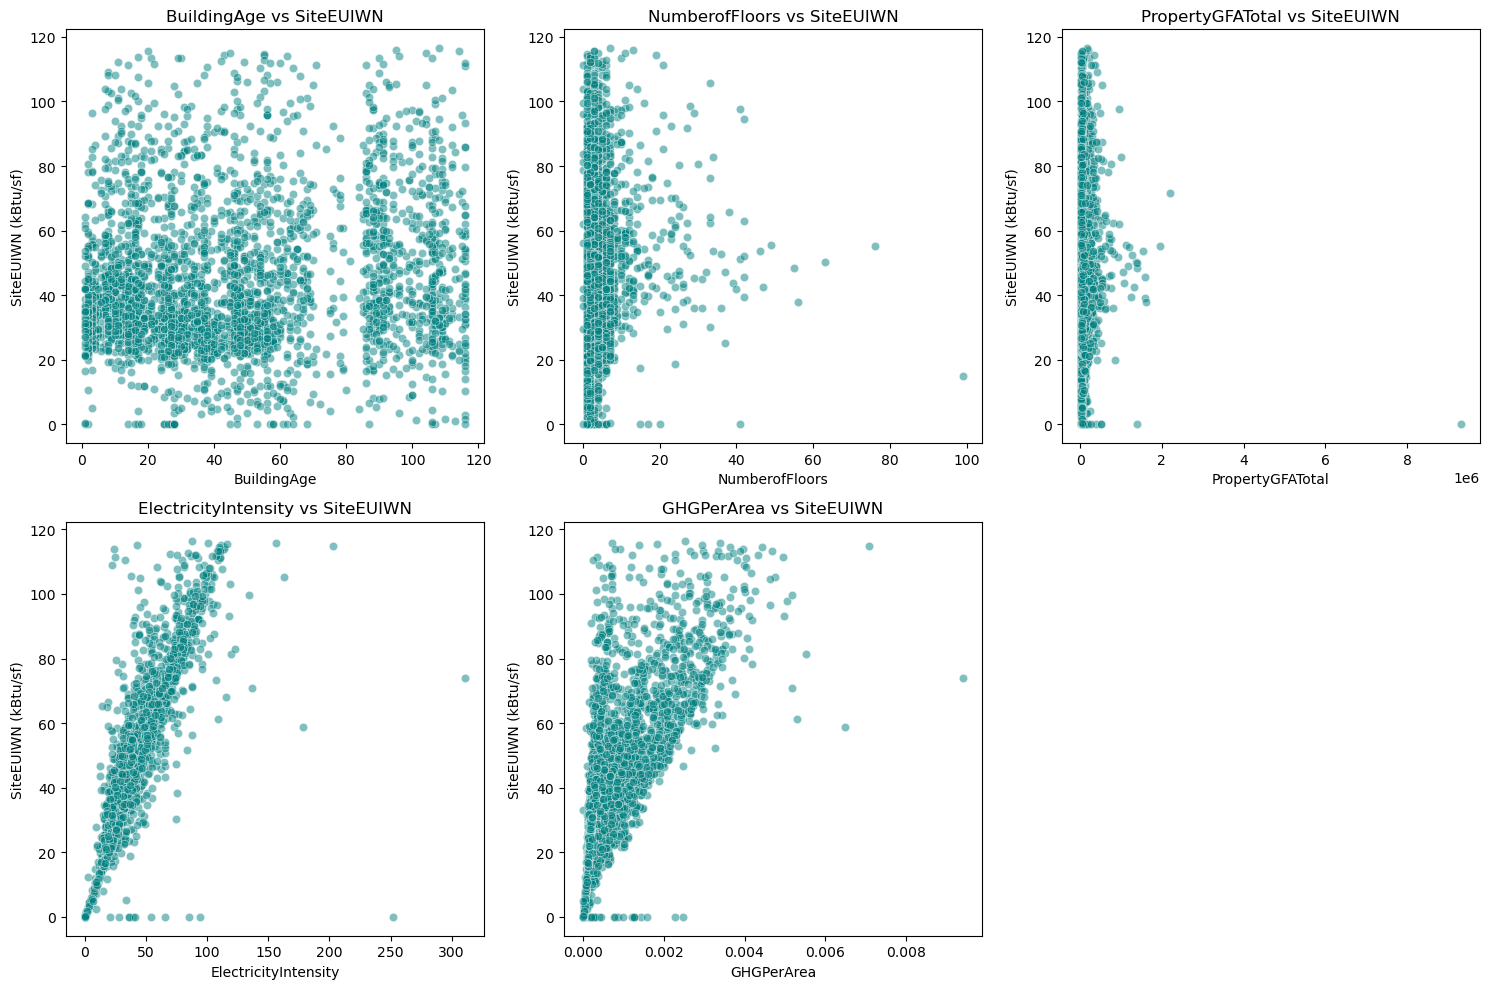

In [68]:
#  Scatterplots : Features numériques vs cible SiteEUIWN
# Objectif : visualiser les relations entre les variables explicatives et la cible
import matplotlib.pyplot as plt
# Liste des features à comparer avec la cible
num_features = ['BuildingAge', 'NumberofFloors', 'PropertyGFATotal',
                'ElectricityIntensity', 'GHGPerArea']
# Utiliser le dataset nettoyé et la cible normalisée
target_clean = df_clean['SiteEUIWN(kBtu/sf)']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features):
    plt.subplot(2, 3, i+1)
    plt.scatter(df_clean[feature], target_clean, alpha=0.5, color='teal', edgecolors='w', linewidths=0.5)
    plt.xlabel(feature)
    plt.ylabel('SiteEUIWN (kBtu/sf)')
    plt.title(f'{feature} vs SiteEUIWN')
plt.tight_layout()
plt.show()


## Visualisation des relations entre les variables explicatives et la cible

**Objectif** : explorer les relations entre les variables numériques et la variable cible `SiteEUIWN(kBtu/sf)` à l’aide de scatterplots.

### Variables comparées :
- `BuildingAge`
- `NumberofFloors`
- `PropertyGFATotal`
- `ElectricityIntensity`
- `GHGPerArea`

### Paramètres du graphique :
- **Figure** : 5 sous-graphes répartis sur une grille 2 × 3
- **Couleur des points** : bleu-vert (`teal`)
- **Transparence** : 50 % (`alpha=0.5`)
- **Contours** : blancs (`edgecolors='w'`)
- **Taille** : 15 × 10

### Interprétation visuelle :
- Certaines variables comme `BuildingAge` ou `NumberofFloors` montrent une dispersion large sans tendance claire.
- `ElectricityIntensity` et `GHGPerArea` présentent une relation plus marquée avec `SiteEUIWN`, suggérant une dépendance énergétique.
-`PropertyGFATotal` semble avoir une faible influence directe, mais pourrait interagir avec d’autres variables.

---


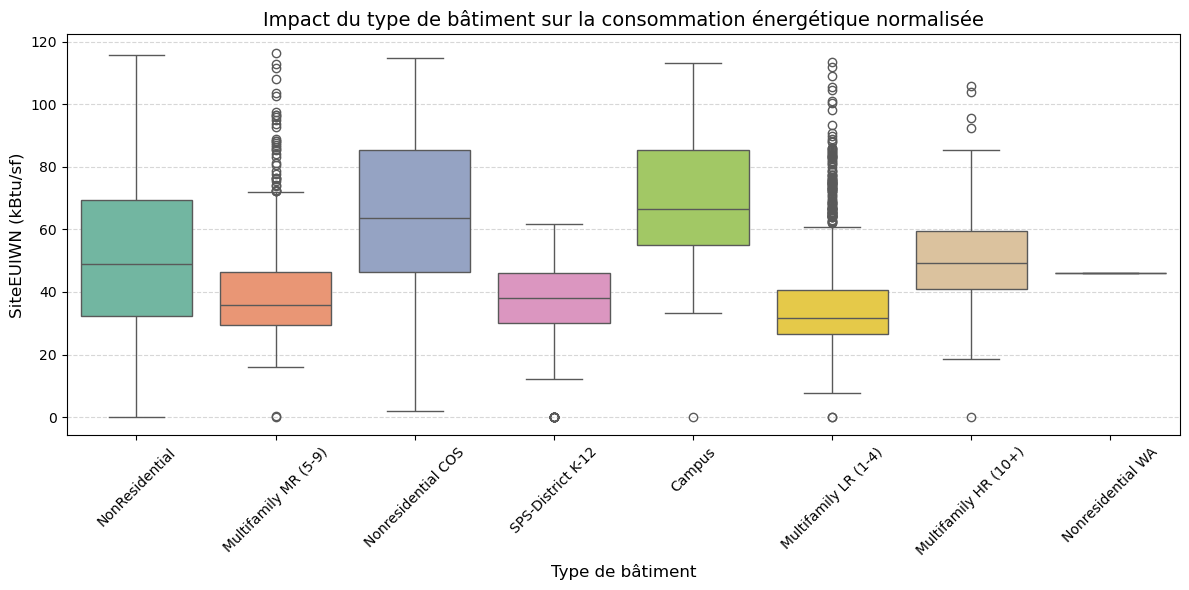

In [69]:
# Boxplot : Impact du type de bâtiment sur la consommation énergétique
# palette utilisée avec hue=x et legend=False
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x='BuildingType', y='SiteEUIWN(kBtu/sf)', hue='BuildingType', data=df_clean, palette='Set2', legend=False)
plt.xticks(rotation=45)
plt.title('Impact du type de bâtiment sur la consommation énergétique normalisée', fontsize=14)
plt.xlabel('Type de bâtiment', fontsize=12)
plt.ylabel('SiteEUIWN (kBtu/sf)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Analyse de la consommation énergétique par type de bâtiment

 **Objectif** : visualiser l’impact du type de bâtiment sur la consommation énergétique normalisée (`SiteEUIWN(kBtu/sf)`).

### Méthode :
- Utilisation d’un **boxplot** pour représenter la distribution de la consommation par catégorie de bâtiment.
- **Palette** : `Set2` avec `hue='BuildingType'` pour colorer chaque boîte.
- **Légende** : désactivée (`legend=False`) pour alléger la visualisation.

### Paramètres du graphique :
- Taille : 12 × 6
- Axe X : `BuildingType` (types de bâtiments)
- Axe Y : `SiteEUIWN(kBtu/sf)` (intensité énergétique normalisée)
- Grille : affichée sur l’axe Y en pointillés

### Interprétation :
Chaque boîte représente :
- La **médiane** (ligne centrale)
- Les **quartiles** (boîte)
- Les **valeurs extrêmes** (points hors de la boîte)

 **Observations clés** :
- Les bâtiments **Nonresidential COS** et **SPS-District K-12** présentent des consommations plus élevées et plus dispersées.
- Les bâtiments **Multifamily LR (1-4)** et **Multifamily MR (5-9)** ont des consommations plus homogènes et modérées.
- La variabilité est importante selon le type, ce qui suggère un effet structurel ou fonctionnel sur la performance énergétique.

---




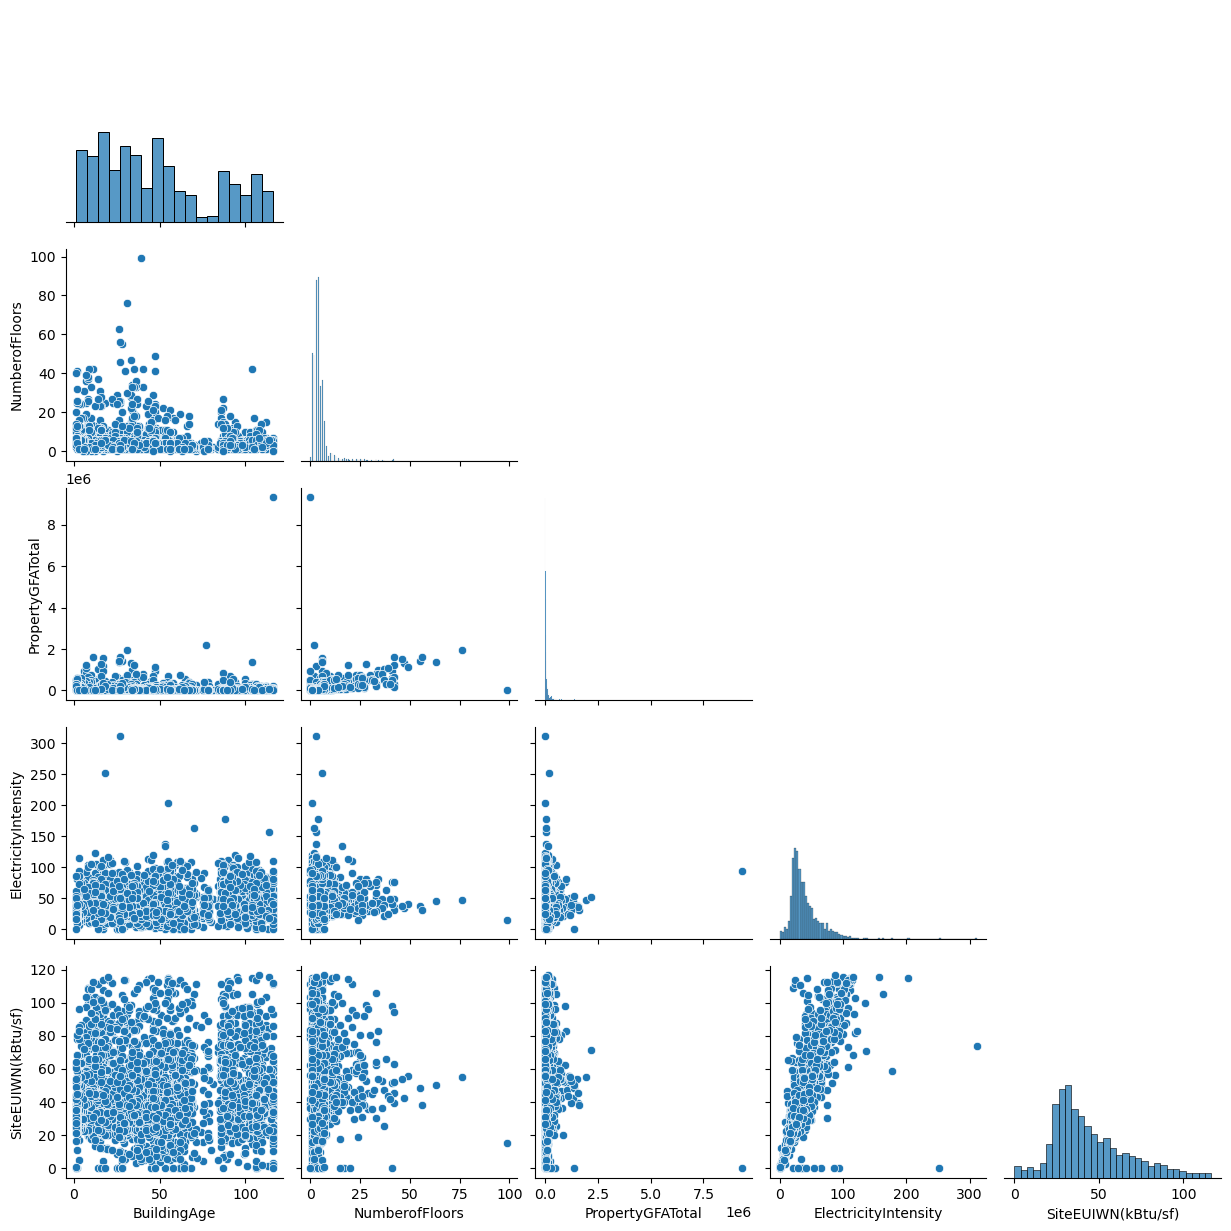

In [70]:
# Pairplot : Relations croisées entre variables numériques
# Objectif : visualiser les interactions entre features et la cible SiteEUIWN
import seaborn as sns
# Sélection des variables pertinentes
selected_features = ['BuildingAge', 'NumberofFloors', 'PropertyGFATotal', 'ElectricityIntensity', 'SiteEUIWN(kBtu/sf)']
# Pairplot avec histogrammes en diagonale
sns.pairplot(df_clean[selected_features], diag_kind='hist', corner=True)


## Relations croisées entre variables numériques : Pairplot
 **Objectif** : explorer les interactions entre les variables explicatives et la cible `SiteEUIWN(kBtu/sf)` à l’aide d’un **pairplot**.

### Variables sélectionnées :
- `BuildingAge`
- `NumberofFloors`
- `PropertyGFATotal`
- `ElectricityIntensity`
- `SiteEUIWN(kBtu/sf)`

### Paramètres du graphique :
- **Type de diagonale** : histogrammes (`diag_kind='hist'`)
- **Affichage** : uniquement la moitié inférieure (`corner=True`)
- **Outil** : `seaborn.pairplot`

### Interprétation :
 Le pairplot permet de :
- Visualiser les **distributions individuelles** sur la diagonale
- Identifier les **relations linéaires ou non linéaires** entre les variables
- Détecter d’éventuels **groupes, tendances ou outliers**

 **Observations clés** :
- `ElectricityIntensity` et `SiteEUIWN(kBtu/sf)` présentent une forte corrélation visuelle
- `PropertyGFATotal` semble faiblement lié à la cible
- Les distributions de `BuildingAge` et `NumberofFloors` sont étendues mais asymétriques

---




# étape 5 : Séparation des features et de la target

In [71]:
# Création des variables X (features) et y (target)
# Objectif : préparer les données pour la modélisation
# Définir la cible (target)
y = df_clean['SiteEUIWN(kBtu/sf)']
# Définir les features (toutes les colonnes sauf la cible)
X = df_clean.drop(columns=['SiteEUIWN(kBtu/sf)'])
# Vérification des dimensions
print(" Dimensions de X :", X.shape)
print(" Dimensions de y :", y.shape)
# Aperçu des premières lignes
X.head(), y.head()


 Dimensions de X : (3119, 38)
 Dimensions de y : (3119,)


(   OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  ZipCode  \
 0              1      2016  NonResidential               Hotel  98101.0   
 1              2      2016  NonResidential               Hotel  98101.0   
 2              3      2016  NonResidential               Hotel  98101.0   
 3              5      2016  NonResidential               Hotel  98101.0   
 6             10      2016  NonResidential               Hotel  98101.0   
 
    CouncilDistrictCode Neighborhood  Latitude  Longitude  NumberofBuildings  \
 0                    7     DOWNTOWN  47.61220 -122.33799                1.0   
 1                    7     DOWNTOWN  47.61317 -122.33393                1.0   
 2                    7     DOWNTOWN  47.61393 -122.33810                1.0   
 3                    7     DOWNTOWN  47.61412 -122.33664                1.0   
 6                    7     DOWNTOWN  47.61390 -122.33283                1.0   
 
    ...  ComplianceStatus  Outlier  BuildingAge  ParkingRati

## Création des variables X (features) et y (target)

 **Objectif** : préparer les données pour l’entraînement d’un modèle prédictif en séparant les variables explicatives (`X`) de la variable cible (`y`).

### Étapes réalisées :
1. **Définition de la cible** :
   - `y = df_clean['SiteEUIWN(kBtu/sf)']`
   - Il s’agit de l’intensité énergétique normalisée du site, exprimée en kBtu/sf.

2. **Définition des features** :
   - `X = df_clean.drop(columns=['SiteEUIWN(kBtu/sf)'])`
   - Toutes les autres colonnes du dataset sont conservées comme variables explicatives.

3. **Vérification des dimensions** :
   - `X.shape` → `(3119, 38)` → 3119 observations, 38 variables explicatives
   - `y.shape` → `(3119,)` → 3119 valeurs cibles

4. **Aperçu des données** :
   - `X.head()` affiche les premières lignes du jeu de données explicatif
   - `y.head()` affiche les premières valeurs de la cible

---



# étpae 6 : Encodage des variables catégorielles



In [72]:
#  Identification des variables catégorielles
# Objectif : repérer les colonnes de type 'object' ou 'category' à encoder
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
print(" Variables catégorielles détectées :")
print(categorical_cols.tolist())

 Variables catégorielles détectées :
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'ComplianceStatus', 'Outlier']


## Identification des variables catégorielles

**Objectif** : repérer les colonnes de type `object` ou `category` dans le dataset `df_clean` afin de les encoder pour la modélisation.

### Méthode :
- Utilisation de `select_dtypes(include=['object', 'category'])` pour filtrer les colonnes non numériques.

### Variables catégorielles détectées :
- `BuildingType`
- `PrimaryPropertyType`
- `Neighborhood`
- `ListOfAllPropertyUseTypes`
- `LargestPropertyUseType`
- `SecondLargestPropertyUseType`
- `ThirdLargestPropertyUseType`
- `ComplianceStatus`
- `Outlier`

### Interprétation :
Ces variables contiennent des informations qualitatives sur :
- Le type de bâtiment et sa fonction principale
- Le quartier et la localisation
- Les usages énergétiques dominants
- Le statut de conformité et la détection d’outliers

---


In [73]:
# Encodage One-Hot des variables catégorielles
# Objectif : transformer les variables catégorielles en variables numériques binaires
# Liste des variables catégorielles à encoder
categorical_features = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']
# Encodage One-Hot (drop_first=True pour éviter la multicolinéarité)
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
# Vérification des dimensions
print(" Dimensions avant encodage :", X.shape)
print(" Dimensions après encodage :", X_encoded.shape)
# Aperçu des premières lignes
X_encoded.head()



 Dimensions avant encodage : (3119, 38)
 Dimensions après encodage : (3119, 117)


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,1,2016,98101.0,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,...,False,False,False,False,False,False,False,False,False,False
1,2,2016,98101.0,7,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,...,False,False,False,False,False,False,False,False,False,False
2,3,2016,98101.0,7,DOWNTOWN,47.61393,-122.33810,1.0,41,956110,...,False,False,False,False,False,False,False,False,False,False
3,5,2016,98101.0,7,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,...,False,False,False,False,False,False,False,False,False,False
6,10,2016,98101.0,7,DOWNTOWN,47.61390,-122.33283,1.0,11,83008,...,False,False,False,False,False,False,False,False,False,False


## Encodage des variables catégorielles et vérification du jeu de données

 **Objectif** : transformer les variables catégorielles en variables numériques binaires via **One-Hot Encoding**, afin de rendre le dataset compatible avec les modèles de machine learning.

### Étapes réalisées :
- Encodage des variables suivantes :
  - `BuildingType`
  - `PrimaryPropertyType`
  - `LargestPropertyUseType`
- Utilisation de `pd.get_dummies()` avec `drop_first=True` pour éviter la **multicolinéarité**.

### Résultat :
| Étape                  | Dimensions du dataset |
|------------------------|------------------------|
| Avant encodage         | (3119, 38)             |
| Après encodage         | (3119, 117)            |

Le nombre de colonnes a fortement augmenté en raison de la création de variables binaires pour chaque modalité catégorielle.

### Aperçu des nouvelles colonnes encodées :
- `LargestPropertyUseType_Restaurant`
- `LargestPropertyUseType_Retail Store`
- `LargestPropertyUseType_Self-Storage Facility`
- `LargestPropertyUseType_Senior Care Community`
- `LargestPropertyUseType_Social/Meeting Hall`
- `LargestPropertyUseType_Strip Mall`
- `LargestPropertyUseType_Supermarket/Grocery Store`
- `LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient`
- `LargestPropertyUseType_Wholesale Club/Supercenter`
- `LargestPropertyUseType_Worship Facility`

 Ces colonnes contiennent des valeurs booléennes (`True`/`False`) indiquant la présence ou non de chaque type d’usage principal.

---


In [74]:
#Vérification qu'il ne reste plus de catégories
X_encoded.dtypes[X_encoded.dtypes == 'object']


Neighborhood                    object
ListOfAllPropertyUseTypes       object
SecondLargestPropertyUseType    object
ThirdLargestPropertyUseType     object
ComplianceStatus                object
Outlier                         object
dtype: object

## Vérification des colonnes catégorielles restantes après encodage

 **Objectif** : s’assurer qu’il ne reste plus de variables de type `object` ou `category` dans le dataset `X_encoded`, afin de garantir sa compatibilité avec les modèles de machine learning.

### Méthode :
- Utilisation de `select_dtypes(include=['object'])` pour détecter les colonnes non encodées.

### Colonnes encore de type `object` :
- `Neighborhood`
- `ListOfAllPropertyUseTypes`
- `SecondLargestPropertyUseType`
- `ThirdLargestPropertyUseType`
- `ComplianceStatus`
- `Outlier`

### Interprétation :
Ces colonnes n’ont pas encore été encodées. Elles contiennent des informations potentiellement utiles mais nécessitent un traitement spécifique :
- Certaines ont un grand nombre de modalités (`Neighborhood`, `ListOfAllPropertyUseTypes`)
- D’autres peuvent être binaires ou ordinales (`ComplianceStatus`, `Outlier`)

---



In [75]:
# ============
# EXPORT DU DATASET FINAL DU NOTEBOOK 2
# ============

import os

# Assurer que le dossier data existe (si notebooks/ est à côté, ../data fonctionne)
os.makedirs("../data", exist_ok=True)

# CHEMIN DE SORTIE
output_csv = "../data/data_prepared2.csv"

# SAUVEGARDE DU DATASET PRÉPARÉ
df_clean.to_csv(output_csv, index=False)

print(" Dataset préparé enregistré pour le Notebook 3 :", output_csv)
print("Dimensions :", df_clean.shape)


 Dataset préparé enregistré pour le Notebook 3 : ../data/data_prepared2.csv
Dimensions : (3119, 39)


## Export du dataset final pour la modélisation

**Objectif** : sauvegarder le dataset nettoyé `df_clean` dans un fichier `.csv` afin de l’utiliser dans le Notebook 3 pour les étapes de modélisation.

